In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd 
import tensorflow as tf 
import numpy as np 
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

2024-03-30 13:00:57.595824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 13:00:57.596048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 13:00:57.785643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0
dir_train = "/kaggle/input/microcontroller-detection/Microcontroller Detection/train/"
dir_test = "/kaggle/input/microcontroller-detection/Microcontroller Detection/test/"
train_df = pd.read_csv("/kaggle/input/microcontroller-detection/Microcontroller Detection/train_labels.csv")
test_df = pd.read_csv("/kaggle/input/microcontroller-detection/Microcontroller Detection/test_labels.csv")
train_df["filename"] = dir_train+train_df['filename']
test_df["filename"] = dir_test+test_df['filename']
train_df.head()
train_df["class"].value_counts()
class_index = {"ESP8266":0,"Heltec_ESP32_Lora":1,"Raspberry_Pi_3":2,"Arduino_Nano":3}
index_class = {v: k for k, v in class_index.items()}
train_df["class"] = train_df["class"].map(class_index)
test_df["class"] = test_df["class"].map(class_index)

train_df["xmin"] = (train_df["xmin"]/train_df["width"])*640
train_df["xmax"] = (train_df["xmax"]/train_df["width"])*640
train_df["ymin"] = (train_df["ymin"]/train_df["height"])*640
train_df["ymax"] = (train_df["ymax"]/train_df["height"])*640


test_df["xmin"] = (test_df["xmin"]/test_df["width"])*640
test_df["xmax"] = (test_df["xmax"]/test_df["width"])*640
test_df["ymin"] = (test_df["ymin"]/train_df["height"])*640
test_df["ymax"] = (test_df["ymax"]/train_df["height"])*640

def concat_to_array(row):
    return [row['xmin'], row['ymin'], row['xmax'], row['ymax']]


train_df['bbox'] = train_df.apply(concat_to_array, axis=1)
test_df['bbox'] = test_df.apply(concat_to_array, axis=1)
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,bbox
0,/kaggle/input/microcontroller-detection/Microc...,800,600,3,253.6,282.666667,444.8,364.800000,"[253.6, 282.66666666666663, 444.79999999999995..."
1,/kaggle/input/microcontroller-detection/Microc...,800,600,1,318.4,259.200000,473.6,407.466667,"[318.4, 259.20000000000005, 473.6, 407.4666666..."
2,/kaggle/input/microcontroller-detection/Microc...,800,600,0,232.0,254.933333,411.2,412.800000,"[232.0, 254.93333333333334, 411.2, 412.8]"
3,/kaggle/input/microcontroller-detection/Microc...,800,600,2,155.2,213.333333,535.2,566.400000,"[155.2, 213.33333333333331, 535.2, 566.4]"
4,/kaggle/input/microcontroller-detection/Microc...,800,600,3,306.4,358.400000,472.8,473.600000,"[306.4, 358.40000000000003, 472.8, 473.6]"


<_BatchDataset element_spec={'images': TensorSpec(shape=(4, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([4, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([4, None, None]), tf.float32, 2, tf.int64)}}>


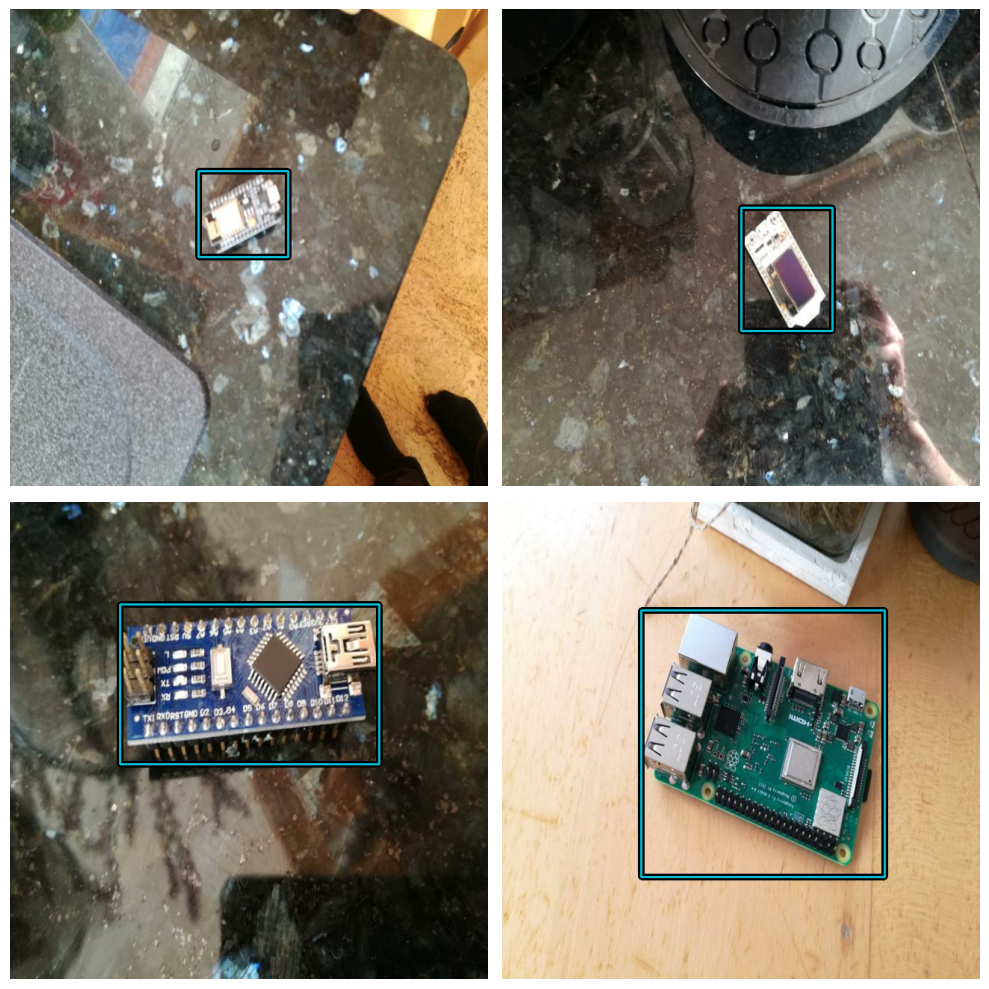

In [8]:
train_paths=train_df['filename'].unique().tolist()
test_paths = test_df['filename'].unique().tolist()

def get_class_bbox(paths_array,train_df):
    classes = []
    bboxes = []
    for path in paths_array : 
        df = train_df[train_df["filename"]==path]
        bboxes.append(df["bbox"].to_list())
        classes.append(df["class"].to_list())
    return classes,bboxes   
train_classes ,train_bboxes= get_class_bbox(train_paths,train_df)
test_classes,test_bboxes = get_class_bbox(test_paths,test_df)
train_bbox = tf.ragged.constant(train_bboxes)
train_class = tf.ragged.constant(train_classes)
train_image_paths = tf.ragged.constant(train_paths)

train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, 
                                               train_class, train_bbox))
test_bbox = tf.ragged.constant(test_bboxes)
test_class = tf.ragged.constant(test_classes)
test_image_paths = tf.ragged.constant(test_paths)

test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, 
                                               test_class, test_bbox))
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (640, 640))
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

augmenter = tf.keras.models.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=1, y_factor=1, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(.20,1.3), bounding_box_format="xyxy"
        ),
    ]
)


resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.1, 0.2),
    bounding_box_format="xyxy",
)
train_ds = train_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
#train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
#test_ds = test_ds.shuffle(BATCH_SIZE * 4)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
#test_ds = test_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    print(inputs)
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_index
    )
visualize_dataset(
    test_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)